In [1]:
%matplotlib inline

## Stochastic Gradient Descent (SGD)
- Simple yet efficient method for fitting linear models.
- Useful when n_samples and n_features is very large - ```partial_fit``` method allows out-of-core learning.
- SGD can use different convex loss functions & penalties.
    - ```loss="log"``` results in a logistic regression model.
    - ```loss="hinge"``` results in a linear SVM model.
- SGD requires a number of parameters, so tuning is non-trivial. It is also sensitive to feature scaling.
- Complexity: roughly a linear function of n_training_samples: time = $O(k n \bar p)$ (k = n_iterations (epochs), p = avg number of non-zero attributes per sample)
- Stopping options:
    - ```early_stopping=True```: input data split into training & validation subsets. Training stops based on prediction score (```score```).
    - ```early_stopping=False```: fitting uses entire dataset. Stop criteria based on objective function.
    - Criterion is evaluated once/epoch. Algorithm stops when criterion doesn't improve ```n_iter_no_change``` times in a row.

## Math: Loss Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def modified_huber_loss(y_true, y_pred):
    z       = y_pred * y_true
    loss    = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.] = 0
    return loss

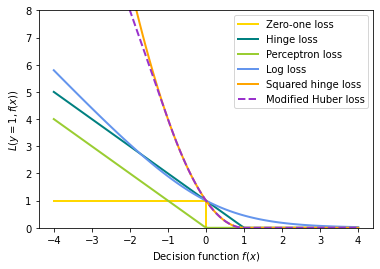

In [3]:
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2

plt.plot([xmin, 0, 0, xmax], 
         [1, 1, 0, 0],   
         color='gold',           
         lw=lw, 
         label="Zero-one loss")

plt.plot(xx, 
         np.where(xx < 1, 1 - xx, 0),    
         color='teal',           
         lw=lw, label="Hinge loss")

plt.plot(xx, 
         -np.minimum(xx, 0),             
         color='yellowgreen',    
         lw=lw, label="Perceptron loss")

plt.plot(xx, 
         np.log2(1 + np.exp(-xx)),       
         color='cornflowerblue', 
         lw=lw, label="Log loss")

plt.plot(xx, 
         np.where(xx < 1, 1 - xx, 0)**2, 
         color='orange',         
         lw=lw, label="Squared hinge loss")

plt.plot(xx, 
         modified_huber_loss(xx, 1),     
         color='darkorchid',     
         lw=lw, linestyle='--', label="Modified Huber loss")

plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$L(y=1, f(x))$")
plt.show()

## [SGD Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
- Works with floating-point data arrays (dense or sparse)
- Fit controlled by loss parameter; fits a linear **Support Vector Machine** by default.
- Regularization is added to the loss function using either a **squared Euclidean L2** norm, an **absolute L1** norm, or a combination.

- Multiclass classifications are supported by combining binary classifiers into a one-vs-all (OVA) scheme. For each of K classes, a binary classifier finds what differentiates it from the other K-1 classes.

- Averaged SGD (AGSD) is supported by setting ```average=True```. This can increase the learning rate -- leading to a training time speedup.

#### Penalty types (via ```penalty="name"```):
- "l2": L2 norm penalty (default)
- "l1": L1 norm penalty
- "elasticnet": convex combination of L1 & L2

In [4]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array([1, 1, 2, 2])

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X, Y)
print(clf.predict([[-0.8, -1]]))

[1]


## Example: Find hyperplane with max margins between two classes
- Using a linear Support Vector Machines classifier, trained using SGD.
- SGD fitted with two arrays: 
    - X (n_samples, n_features) = training samples
    - y (n_samples) = targe values (class labels)

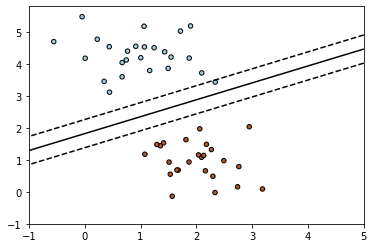

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_blobs

# 2 blobs, 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)
clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx     = np.linspace(-1, 5, 10)
yy     = np.linspace(-1, 5, 10)
X1, X2 = np.meshgrid(xx, yy)
Z      = np.empty(X1.shape)

for (i, j), val in np.ndenumerate(X1):
    x1      = val
    x2      = X2[i, j]
    p       = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
    
plt.contour(X1, X2, Z, 
            [-1.0, 0.0, 1.0], 
            colors='k', 
            linestyles=['dashed', 'solid', 'dashed'])

plt.scatter(X[:, 0], 
            X[:, 1], 
            c=Y, 
            cmap=plt.cm.Paired,
            edgecolor='black', s=20)

plt.axis('tight')
plt.show()

## Example: Multiclass SGD, Iris dataset
- Hyperplanes correspond to three OVA classifiers (dashed lines)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import SGDClassifier

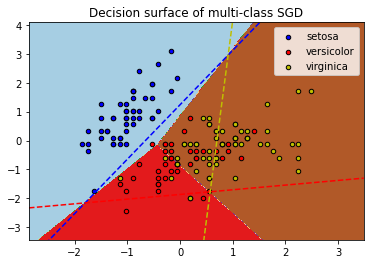

In [7]:
# use iris dataset & first two features. We could
# avoid this ugly slicing by using a two-dim dataset

iris   = datasets.load_iris()
X      = iris.data[:, :2]
y      = iris.target
colors = "bry"
# shuffle
idx    = np.arange(X.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
X      = X[idx]
y      = y[idx]
# standardize
mean   = X.mean(axis=0)
std    = X.std(axis=0)
X      = (X - mean) / std
# step size in mesh
h      = .02

clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy       = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

# Plot decision boundary. Assign color to each point in mesh
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z  = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('tight')

# Plot training points
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], 
                X[idx, 1], 
                c=color, 
                label=iris.target_names[i],
                cmap=plt.cm.Paired, 
                edgecolor='black', 
                s=20)

plt.title("Decision surface of multi-class SGD")
plt.axis('tight')

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_


def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)


for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)
plt.legend()
plt.show()

## Example: Plot decision function of a weighted dataset
- Shown: point size is proportional to its weight.

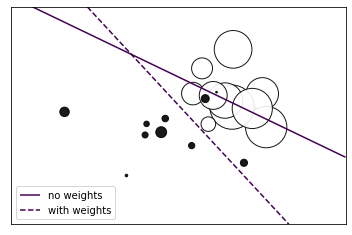

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# 20 random points. assign bigger weight to last 10.
np.random.seed(0)
X                   = np.r_[np.random.randn(10,2)+[1,1], 
                            np.random.randn(10,2)]
y                   = [1]*10 + [-1]*10
sample_weight       = 100 * np.abs(np.random.randn(20))
sample_weight[:10] *= 10
xx, yy              = np.meshgrid(np.linspace(-4, 5, 500), 
                                  np.linspace(-4, 5, 500))
plt.figure()
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, 
            s=sample_weight, 
            alpha=0.9,
            cmap=plt.cm.bone, 
            edgecolor='black')

# fit the unweighted model
clf        = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y)
Z          = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z          = Z.reshape(xx.shape)
no_weights = plt.contour(xx, yy, Z, levels=[0], linestyles=['solid'])

# fit the weighted model
clf             = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y, sample_weight=sample_weight)
Z               = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z               = Z.reshape(xx.shape)
samples_weights = plt.contour(xx, yy, Z, levels=[0], linestyles=['dashed'])

plt.legend([no_weights.collections[0], 
            samples_weights.collections[0]],
           ["no weights", "with weights"], 
           loc="lower left")

plt.xticks(())
plt.yticks(())
plt.show()

## Comparison: Solver performance on Digits dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
heldout     = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds      = 20
X, y        = datasets.load_digits(return_X_y=True)
classifiers = [
    ("SGD",                   SGDClassifier(max_iter=100)),
    ("ASGD",                  SGDClassifier(average=True)),
    ("Perceptron",            Perceptron()),
    ("Passive-Aggressive I",  PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0, 
                                                          tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0, 
                                                          tol=1e-4)),
    ("SAG",                   LogisticRegression(solver='sag', 
                                                 tol=1e-1, 
                                                 C=1.e4 / X.shape[0]))
]
xx = 1. - np.array(heldout)
print(xx)

[0.05 0.1  0.25 0.5  0.99]


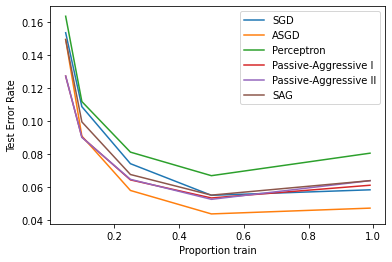

In [11]:
for name, clf in classifiers:
    rng, yy = np.random.RandomState(42), []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

## Example: Find SVM Hyperplane, unbalanced classes
- note: this will also work using by replacing ```SVC(kernel="linear")``` with ```SGDClassifier(loss="hinge")```. Example: ```clf=SGDClassifier(n_iter=100, alpha=0.01)```.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [13]:
# two random clusters
n_samples_1  = 1000
n_samples_2  = 100
centers      = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y         = make_blobs(n_samples    = [n_samples_1, n_samples_2],
                          centers      = centers,
                          cluster_std  = clusters_std,
                          random_state = 0, 
                          shuffle      = False)

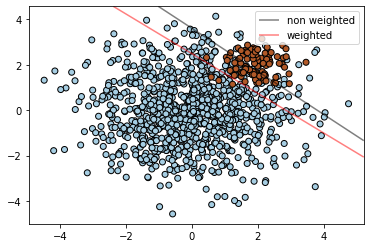

In [14]:
# fit model, get hyperplane (simple, weighted)
clf  = svm.SVC(kernel='linear', C=1.0)
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
clf.fit(X, y)
wclf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

# plot decision functions
ax     = plt.gca()
xlim   = ax.get_xlim()
ylim   = ax.get_ylim()
# create grid to evaluate model
xx     = np.linspace(xlim[0], xlim[1], 30)
yy     = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy     = np.vstack([XX.ravel(), YY.ravel()]).T
# get hyperplane
Z      = clf.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
a     = ax.contour(XX, YY, Z, 
                   colors='k', levels=[0], alpha=0.5, linestyles=['-'])
# get hyperplane (weighted)
Z     = wclf.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins for weighted classes
b     = ax.contour(XX, YY, Z, 
                   colors='r', levels=[0], alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], 
            b.collections[0]], 
           ["non weighted", "weighted"],
           loc="upper right")
plt.show()

## [SGD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)
- Loss function options (via ```loss="name"```):
    - "squared_loss" = ordinary least squares
    - "huber" = huber loss for robust regression
    - "epsilon_insensitive" = linear SVD
- Penalty options are the same as above for classification.
- SGDR also supports averaged SGD.
- SGDR also supports SAG.

In [15]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

n_samples, n_features = 10, 5
rng                   = np.random.RandomState(0)
y                     = rng.randn(n_samples)
X                     = rng.randn(n_samples, n_features)

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)
print(reg.predict([[1.,1.,1.,1.,1.],
                   [2.,2.,2.,2.,2.],
                   [3.,3.,3.,3.,3.]]))

[0.90954828 1.20177152 1.49399476]


## SGD with Sparse Data
- Built-in sparse data support (any format supported by [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).)
- Use [CSR matrix format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) for max efficiency.

## Example: Text document classification, sparse features
- Bag-of-words approach
- Uses scipy.sparse matri to save features
- Compares various classifiers

In [16]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [17]:
# load 20newsgroups dataset (18K posts, 20 topics, training/test subsets)

categories, remove = None, ()

data_train = fetch_20newsgroups(subset='train', #categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', #categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')
!ls ~/scikit_learn_data

data loaded
20news-bydate_py3.pkz		kddcup99_10-py3       openml
20newsgroup_vectorized_py3.pkl	lfw_home	      RCV1
cal_housing_py3.pkz		mldata		      reuters
covertype			mnist_benchmark_data  species_coverage_py3.pkz
covertype_benchmark_data	olivetti_py3.pkz


In [18]:
target_names = data_train.target_names

In [19]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (len(data_train.data), 
                                                 data_train_size_mb))
print("%d documents - %0.3fMB (test set)"     % (len(data_test.data), 
                                                 data_test_size_mb))
print("%d categories" % len(target_names))

11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)
20 categories


In [20]:
y_train, y_test = data_train.target, data_test.target
use_hashing     = True
n_features      = 2**16 # original default?

print("Extracting features from training data using sparse vectorizer")
t0 = time()
if use_hashing:
    vectorizer = HashingVectorizer(stop_words     = 'english', 
                                   alternate_sign = False,
                                   n_features     = n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf = True, 
                                 max_df       = 0.5,
                                 stop_words   = 'english')
    X_train = vectorizer.fit_transform(data_train.data)
    
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

Extracting features from training data using sparse vectorizer
done in 2.397216s at 9.200MB/s
n_samples: 11314, n_features: 65536


In [21]:
print("Extracting features from test data using same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

Extracting features from test data using same vectorizer
done in 1.471577s at 9.378MB/s
n_samples: 7532, n_features: 65536


In [22]:
if use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

print(feature_names)

None


In [23]:
select_chi2 = 10

if select_chi2:
    print("Extracting %d best features via chi-squared test" % select_chi2)
    t0      = time()
    ch2     = SelectKBest(chi2, k=select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test  = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))

Extracting 10 best features via chi-squared test
done in 0.504959s


In [24]:
if feature_names:
    feature_names = np.asarray(feature_names)
print(feature_names)

None


In [25]:
# train & test 15 different classifiers. get performance for each.

print_top10 = True
print_report = True
print_cm     = True

def benchmark(clf):
    print("Training: ", clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density:        %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(                 max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(       n_neighbors=10), "kNN"),
        (RandomForestClassifier(                   ), "Random forest")):
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty = penalty, 
                                       dual    = False,
                                       tol     = 1e-3)))
    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha    = .0001, 
                                           max_iter = 50,
                                           penalty  = penalty)))

# Train SGD with Elastic Net penalty
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha    = .0001, 
                                       max_iter = 50,
                                       penalty  = "elasticnet")))

# Train NearestCentroid without threshold
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("Naive Bayes")
results.append(benchmark(MultinomialNB( alpha= 0.01)))
results.append(benchmark(BernoulliNB(   alpha= 0.01)))
results.append(benchmark(ComplementNB(  alpha= 0.1)))

print("LinearSVC with L1-based feature selection")
# smaller C = stronger regularization. more regularization, more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
Training:  RidgeClassifier(solver='sag', tol=0.01)


/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 0.252s
test time:  0.001s
accuracy:   0.259
dimensionality: 10
density:        1.000000
classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.53      0.66      0.59       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.75      0.58      0.66       390
               rec.autos       0.66      0.47      0.55       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       0.07      0.92      0.14       399
               sci.crypt       0.70      0.69      0.70       396
         sci.elect

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 1.499s
test time:  0.196s
accuracy:   0.224
classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.17      0.07      0.10       319
           comp.graphics       0.18      0.03      0.05       389
 comp.os.ms-windows.misc       0.58      0.45      0.51       394
comp.sys.ibm.pc.hardware       0.10      0.02      0.04       392
   comp.sys.mac.hardware       0.06      0.01      0.01       385
          comp.windows.x       0.19      0.05      0.08       395
            misc.forsale       0.73      0.53      0.62       390
               rec.autos       0.68      0.38      0.49       396
         rec.motorcycles       0.08      0.01      0.02       398
      rec.sport.baseball       0.07      0.90      0.13       397
        rec.sport.hockey       0.09      0.01      0.02       399
               sci.crypt       0.79      0.63      0.70       396
         sci.electronics       0.09      0.01      0.02       

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 0.094s
test time:  0.001s
accuracy:   0.251
dimensionality: 10
density:        1.000000
classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.53      0.66      0.59       394
comp.sys.ibm.pc.hardware       0.06      0.77      0.11       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.75      0.59      0.66       390
               rec.autos       0.67      0.47      0.55       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       0.00      0.00      0.00       399
               sci.crypt       0.69      0.70      0.69       396
         sci.elect

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.53      0.61      0.57       394
comp.sys.ibm.pc.hardware       0.07      0.00      0.00       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.21      0.01      0.02       395
            misc.forsale       0.77      0.52      0.62       390
               rec.autos       0.70      0.46      0.55       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.09      0.03      0.05       397
        rec.sport.hockey       0.07      0.92      0.14       399
               sci.crypt       0.89      0.61      0.72       396
         sci.electronics       0.16      0.01      0.02       393
                 sci.med       0.09      0.00      0.00       396
         

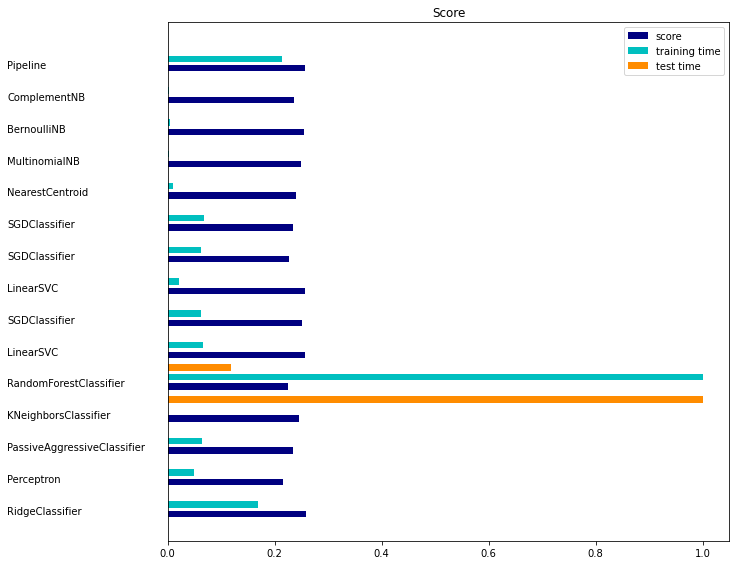

In [26]:
# add plots
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time     = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()